# 文本聚类作业报告
    - 邵智轩
    - 1400012141
    - 物理学院
    
## 总览
    
### 数据
中文微博文本

### 任务
聚类，类的个数$K$为可调参数

### 特征及维数
特征直接采用`sklearn.feature_extraction.text.tfidfVectorizer`提取，这里有两个可调参数：`min_df`和`use_idf`。其中，简单的实验发现多数情况下`use_idf = True`的分类效果较好。而`min_df`会将总频数低于某一设定值的词语从Vocabulary 中删去。

使用`sklearn.decomposition.TruncatedSVD`进一步降维至`n_components`，这是一个可调参数。

### 聚类评价
虽然聚类通常属于无监督学习，但我们其实掌握数据的某一种分类信息（分成“财经，房产，健康，教育，军事，科技，体育，娱乐，证券”，共9个类），所以可以对聚类效果给出评价。助教建议使用“conditional entropy of the classes given the cluster assignments”作为评价，熵值越低认为聚类得越好：
\begin{equation}
    H(C|K)=-\sum_{c=1}^{|C|}\sum_{k=1}^{|K|}\frac{n_c,k}{n}\log\left(\frac{n_{c,k}}{n_k}\right)
\end{equation}
注意到这与所谓的“homogeneity score”$h$是等价的，定义为：
\begin{equation}
    h=1-\frac{H(C|K)}{H(C)}
\end{equation}

这个值在$[0,1]$之间，越大聚类效果越好。可以试想，聚类的个数越多，$h$总会越高，所以我认为不应单纯采用熵作为评价。下面考虑一些修正后的评价：

`sklearn.metrics`中提供了很多measure，其中`homogeneity_completeness_v_measure`函数返回三个score，其中第一个值为homogeneity score $h$，后两个分别为“completeness score”$c$：
\begin{equation}
    c=1-\frac{H(K|C)}{H(K)}
\end{equation}
和“v_measure” $v$：
\begin{equation}
    v=2\frac{h\cdot c}{h+c}
\end{equation}
当聚类个数$K$过多时，后两个score就会下降。

另一个指标是`adjusted_mutual_information`。

### 聚类方法
采用余弦相似度（`scipy.spatial.distance.pdist(metric='cosine')`）定义文本之间的距离。然后用Hierarchical Clustering中的Agglomerative（bottom-up)算法，并将类之间的linkage选为“average”。`scikit-learn`库中`AgglomerativeClustering(linkage="average")`可以实现此功能。我手写了`My_Agglomerative`函数，并比对结果。实验证明两个函数给出的聚类完全相同（聚类预测的Adjusted mutual information = 1），但是当样本量$n$很大时，运算效率差异非常大，这可能是自己写的算法不够合理。

## 实验结果


In [1]:
import text_data
from sklearn.feature_extraction import text
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
import score_data
import numpy as np
from sklearn import metrics
from scipy import spatial,cluster
import My_Agglomerative as myag

pdist: 0.0007321291024150066
scipy: 0.015261059340592952


100%|███████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 1127.58it/s]


My Agglometative: 0.10706982223497606
[6 6 9 4 8 9 2 6 3 0 0 4 1 9 2 4 2 6 4 0 0 1 3 0 3 1 0 1 0 5 0 4 2 4 0 7 5
 9 7 3 5 4 1 2 1 9 8 4 3 0 0 4 8 9 2 3 0 5 6 8 0 3 4 4 1 7 9 4 1 6 1 0 7 3
 0 4 8 0 1 7 7 1 6 8 6 4 3 7 2 1 0 1 7 5 8 0 4 2 4 1]
Adjusted Mutual Information: 1.0


以上验证了我的算法是正确的（给出与标准库函数相同的预测，up to a permutation）。

用`GridSearch.py`寻找最优超参数，如下的参数的效果就还不错

In [2]:
use_idf=True
least_freq=5
n_clusters=13
n_components=100
affinity='cosine'
linkage='average'

filename=str(n_clusters)+r"_"+str(least_freq)+r"_"+str(n_components)+r".txt"

In [3]:
data=text_data.load_data(type="str")

100%|███████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  2.24it/s]


In [4]:
countVectorizer=text.TfidfVectorizer(input='content',min_df=least_freq, use_idf=use_idf)# 最少总共出现过min_df次
term_freq=countVectorizer.fit_transform(data)
print('词典总词数:',len(countVectorizer.vocabulary_))
#print(countVectorizer.vocabulary_)

词典总词数: 11449


In [5]:
svd=TruncatedSVD(n_components=n_components)
svd_result=svd.fit_transform(term_freq)
print("Explained variance of the SVD step: {}%".format(
    int(svd.explained_variance_ratio_.sum() * 100)))

Explained variance of the SVD step: 13%


In [6]:
# 为了防止全零行计算cosine affinity 出错补上一个标志
def mark_allzeros(matrix):
    mark=np.prod(matrix==0,axis=1)
    return np.concatenate((matrix,mark.reshape((len(mark),1))),axis=1)

marked_svd=mark_allzeros(svd_result)

In [7]:
Dist=spatial.distance.pdist(marked_svd,metric="cosine")
sci_result=cluster.hierarchy.linkage(Dist,method="average")

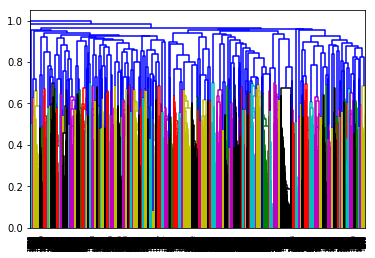

In [13]:
from matplotlib import pyplot as plt
dn=cluster.hierarchy.dendrogram(sci_result)
plt.show()# 树状图

In [9]:
#sk_Aggl=AgglomerativeClustering(n_clusters=n_clusters,affinity=affinity,linkage=linkage)
#sk_pred=sk_Aggl.fit_predict(marked_svd)

In [10]:
my_pred=myag.MyAgglomerativeClustering(Dist)
label_pred=myag.MyAggl_pred(np.array(my_pred,dtype=int)[:,:2],n_clusters=n_clusters)
text_data.save_json([int(i) for i in label_pred],filename)

In [11]:
label_pred=text_data.load_json(filename)

In [12]:
for labels_pred in [my_pred]:
    count_table=score_data.count_table(text_data.init_num_by_cls,labels_pred,n_clusters)
    print(count_table)
    total_entropy=score_data.total_entropy(count_table)
    print("Total Entropy:",total_entropy)
    print("homogeneity_score",metrics.homogeneity_completeness_v_measure(text_data.labels_true(),labels_pred))

[[ 117  109   88    6 1786   99    1    1   18   62   81    4    3]
 [  86  142    7    4  850   27    0    0   43    5   43    4    0]
 [ 535   30    7    2   43   14    1    0    1    0   32    5    0]
 [ 150  157    2   10   67   34    0    0    0    0   26    1    0]
 [   3   27    3    5   20  694    0    2    0    0   37    0    0]
 [  12   55  451    6  514   63    0    0    3  199   39   15   40]
 [  54  223    1  481  106   90   74    2    0    2 2234   58    0]
 [  71 1640   11   53  176  146    1    2    3    4  102   46    0]
 [   2    6   16    2 1088   10    1    0    1   18   20    1    2]]
Total Entropy: -1.2239146970946375
homogeneity_score (0.39710183733996385, 0.431254414058614, 0.41347408169976946)


总结：聚类的结果中，有许多聚类的熵很低（该聚类中的大部分文本都属于同一分类）。从无监督的角度来说，这个简单的算法达到这个效果，我认为基本可以满意。